# Machine collective variables with `mlcolvar`

- General workflow using `DeepTDA` as an example
- Different learning approaches and training objectives
- PLUMED interface


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mlcolvar.utils.plot import paletteFessa

from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep
mfep = muller_brown_mfep()

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Outline

Typically, the process of constructing a data-driven CV requires the following ingredients:
1) A dataset (with input features and possibly targets or labels) 
2) A model (e.g. a neural network) and an objective function.

Once we have them, we can combine them and optimize the CV (via a trainer object).

Finally, we can export the CV in order to be deployed in PLUMED.

# Load data and create dataset

We will use the unbiased data in the metastable states we produced in the previous notebook

In [25]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

n_states = 2
filenames = ["../1_enhanced_sampling/simulations/unbiased_sims/A/COLVAR",
             "../1_enhanced_sampling/simulations/unbiased_sims/B/COLVAR",]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, stop=8000, stride=4)

# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2000, 17)
Class 1 dataframe shape:  (2000, 17)

 - Loaded dataframe (4000, 17): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels']
 - Descriptors (4000, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [4000, 2], "labels": [4000] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

However, this approach is raher limiting as it's difficult to identify them.

One alternative can be, for example, to combine some variables to make them more *collective*.

 The easiest approach is to combine them linearly

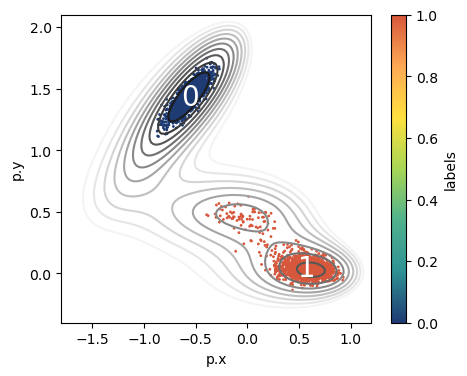

In [26]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075,
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')

# Initialize and train model

### Initialize

In [49]:
from mlcolvar.cvs import DeepTDA

# Parameters
n_cvs = 1                   # Dimension of CV space
target_centers = [-5, 5]    # Centers of target Gaussians
target_sigmas = [0.2, 0.2]  # Width of target Gaussians
nn_layers = [2,12,12,1]     # Architecture of NN

options = {'nn' : {'activation' : 'shifted_softplus'}}

# Initialize DeepTDA model
model = DeepTDA(n_states=n_states, 
                n_cvs=1,
                target_centers=target_centers, 
                target_sigmas=target_sigmas, 
                layers=nn_layers)

### Train

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [1, 2]   | [1, 2]   
2 | nn      | FeedForward   | 205    | [1, 2]   | [1, 1]   
-----------------------------------------------------------------
205       Trainable params
0         Non-trainable params
205       Total params
0.001     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 65.83it/s, v_num=9] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 60.31it/s, v_num=9]


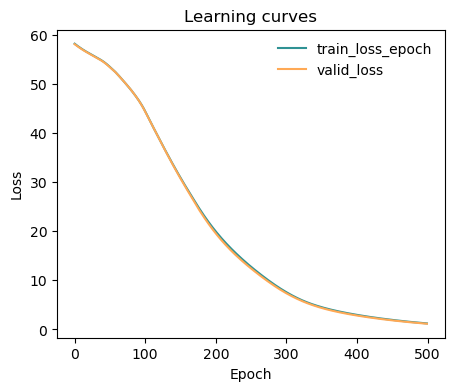

In [50]:
import lightning
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics

# define callbacks
metrics = MetricsCallback()

# define trainer
trainer = lightning.Trainer(callbacks=[metrics],
                            max_epochs=500, 
                            logger=None,
                            enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

ax = plot_metrics(metrics.metrics,
                  keys=['train_loss_epoch','valid_loss'],
                  colors=['fessa1','fessa5'],
                  yscale='linear')

### Analyze CV space

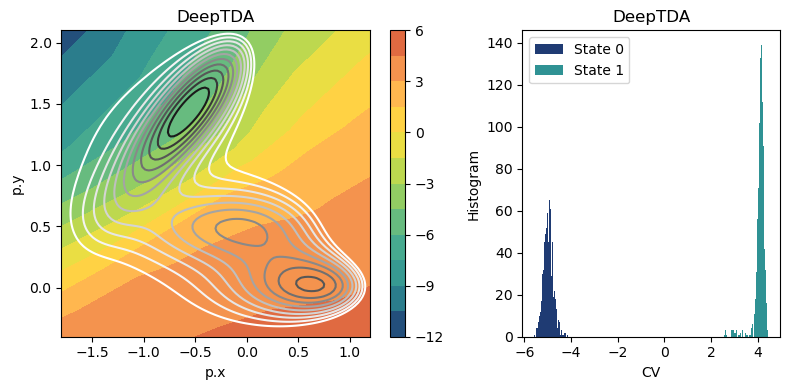

In [51]:
fig,axs = plt.subplots( 1, 2, figsize=(8,4), gridspec_kw={'width_ratios' : [3,2]} )

ax = axs[0]
plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('DeepTDA')
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

ax = axs[1]
X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}', color=paletteFessa[i])

ax.set_xlabel('CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.tight_layout()
plt.show()

### Export frozen CV model to be used in PLUMED

In [52]:
model.to_torchscript('model_tda.pt', method='trace')

DeepTDA(
  original_name=DeepTDA
  (loss_fn): TDALoss(original_name=TDALoss)
  (norm_in): Normalization(original_name=Normalization)
  (nn): FeedForward(
    original_name=FeedForward
    (nn): Sequential(
      original_name=Sequential
      (0): Linear(original_name=Linear)
      (1): ReLU(original_name=ReLU)
      (2): Linear(original_name=Linear)
      (3): ReLU(original_name=ReLU)
      (4): Linear(original_name=Linear)
    )
  )
)

# Run simulations

In [54]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_metad_tda_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_tda_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_tda_sims.sh', returncode=0)

No protocol specified
No protocol specified


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


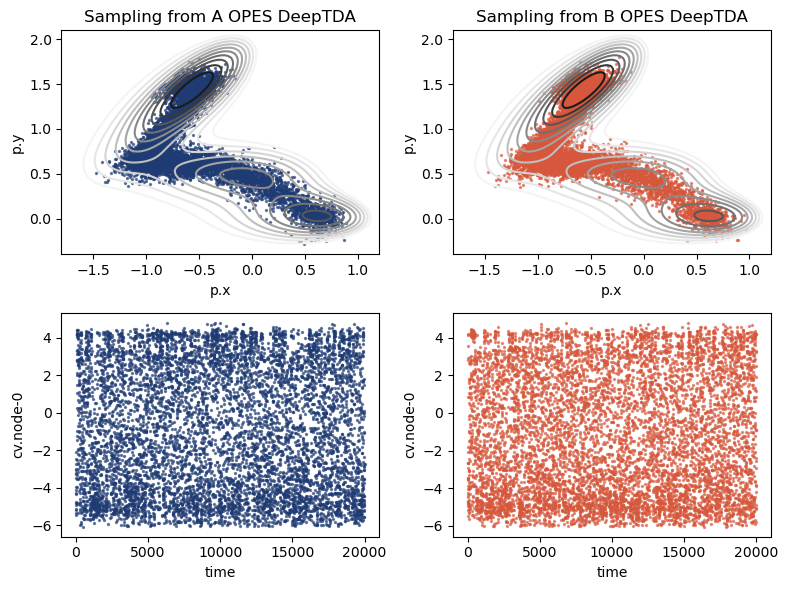

In [65]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/opes_metad_tda/A/COLVAR', f'simulations/opes_metad_tda/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s} OPES DeepTDA')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'cv.node-0', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

### Compute FES 

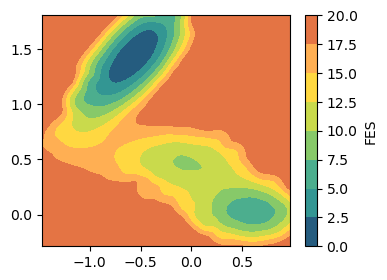

In [69]:
from mlcolvar.utils.fes import compute_fes

fig, ax = plt.subplots(1,1,figsize=(4, 3))
weights = np.exp(sampling['opes.bias'].values)
fes,bins,_,_ = compute_fes(sampling[['p.x', 'p.y']].values, weights=weights, kbt=1, plot=True, num_samples=200, eps=1e-6, bandwidth=0.02, scale_by='range', plot_max_fes=24, ax=ax)